# Cart Pole

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt

from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#  set animations to jshtml to render them in browser
#plt.rcParams["animation.html"] = "jshtml"

In [2]:
# initalize environment
env = gym.make("CartPole-v1", render_mode="rgb_array")

# if running locally, you can also use the human render mode
# env = gym.make("CartPole-v1", render_mode="human")

observation, info = env.reset(seed=19)

# we will store our frames in this list
frames = []

# run one episode
truncated = False
terminated = False
while not (truncated or terminated):
    frames.append(env.render())

    # select a random action
    action = env.action_space.sample()
    # action = agent.predict(observation)

    # apply the selected action to the environment
    observation, reward, terminated, truncated, info = env.step(action)

    # agent.train(reward)

env.close()

Authorization required, but no authorization protocol specified



In [3]:

def replay(frames):
    fig, ax = plt.subplots()
    img = ax.imshow(frames[0])
    ax.axis("off")

    def update(frame):
        img.set_data(frame)
        return [img]

    anim = FuncAnimation(fig, update, frames=frames, interval=30, blit=True)
    plt.close(fig)
    return HTML(anim.to_jshtml())

replay(frames)

## Very Naive Approach

In [4]:
import numpy as np

class Agent:
    def act(self, obs):
        raise NotImplementedError()

class RandomAgent(Agent):
    def __init__(self, seed=19):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

    def act(self, obs):
        return self.rng.choice([0,1])

class AngularAgent(Agent):
    def act(self, obs):
        # 2 is the pole angle
        if obs[2] > 0:
            return 1
        else:
            return 0

def evaluate_agent(agent: Agent, n_episodes=10):
    # initalize environment
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    observation, info = env.reset(seed=19)
    total_reward = 0
    for i in range(n_episodes):
        terminated = False
        truncated = False
        while not (terminated or truncated):
            action = agent.act(observation)
            # apply the selected action to the environment
            observation, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
        env.reset()

    return total_reward / n_episodes

In [5]:
def play_episode(agent):
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    observation, info = env.reset(seed=19)

    frames = []

    terminated = False
    truncated = False
    while not (terminated or truncated):
        frames.append(env.render())
        action = agent.act(observation)
        # apply the selected action to the environment
        observation, reward, terminated, truncated, info = env.step(action)
    
    return replay(frames)

In [6]:
play_episode(AngularAgent())

Authorization required, but no authorization protocol specified



In [7]:
agent = RandomAgent()

evaluate_agent(agent)

23.3

In [8]:
agent = AngularAgent()
evaluate_agent(agent)

41.7

In [9]:
env = gym.make("CartPole-v1", render_mode="rgb_array")

# if running locally, you can also use the human render mode
# env = gym.make("CartPole-v1", render_mode="human")

observation, info = env.reset(seed=19)

# we will store our frames in this list
frames = []

# run one episode
truncated = False
terminated = False
while not (truncated or terminated):
    frames.append(env.render())

    # select a random action
    action = env.action_space.sample()
    # action = agent.predict(observation)

    # apply the selected action to the environment
    observation, reward, terminated, truncated, info = env.step(action)

    # agent.train(reward)

env.close()

## Data-Driven Approach

1. collect random data
2. train a simple predictor, if the absolute pole angle will increase
3. use predictor to select actions

In [10]:
def generate_random_data(n=10000):
    data = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")

    # if running locally, you can also use the human render mode
    # env = gym.make("CartPole-v1", render_mode="human")

    observation, info = env.reset(seed=19)

    for i in range(n):
        # select a random action
        action = env.action_space.sample()

        data.append({"action": action, "observation": observation})

        # apply the selected action to the environment
        observation, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
            env.reset()
    return data

data = generate_random_data()

In [11]:
x = []
y = []

for t in range(len(data) - 1):
    # compute difference in pole angle
    d = abs(data[t+1]["observation"][2]) < abs(data[t]["observation"][2])
    x.append(data[t]["observation"])

    action = data[t]["action"]
    
    if d < 0:
        correct_action = action 
    else:
        correct_action = (action +1) % 2
    y.append(correct_action)

x = np.stack(x)
y = np.array(y)

In [12]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=5)

model.fit(x, y)

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


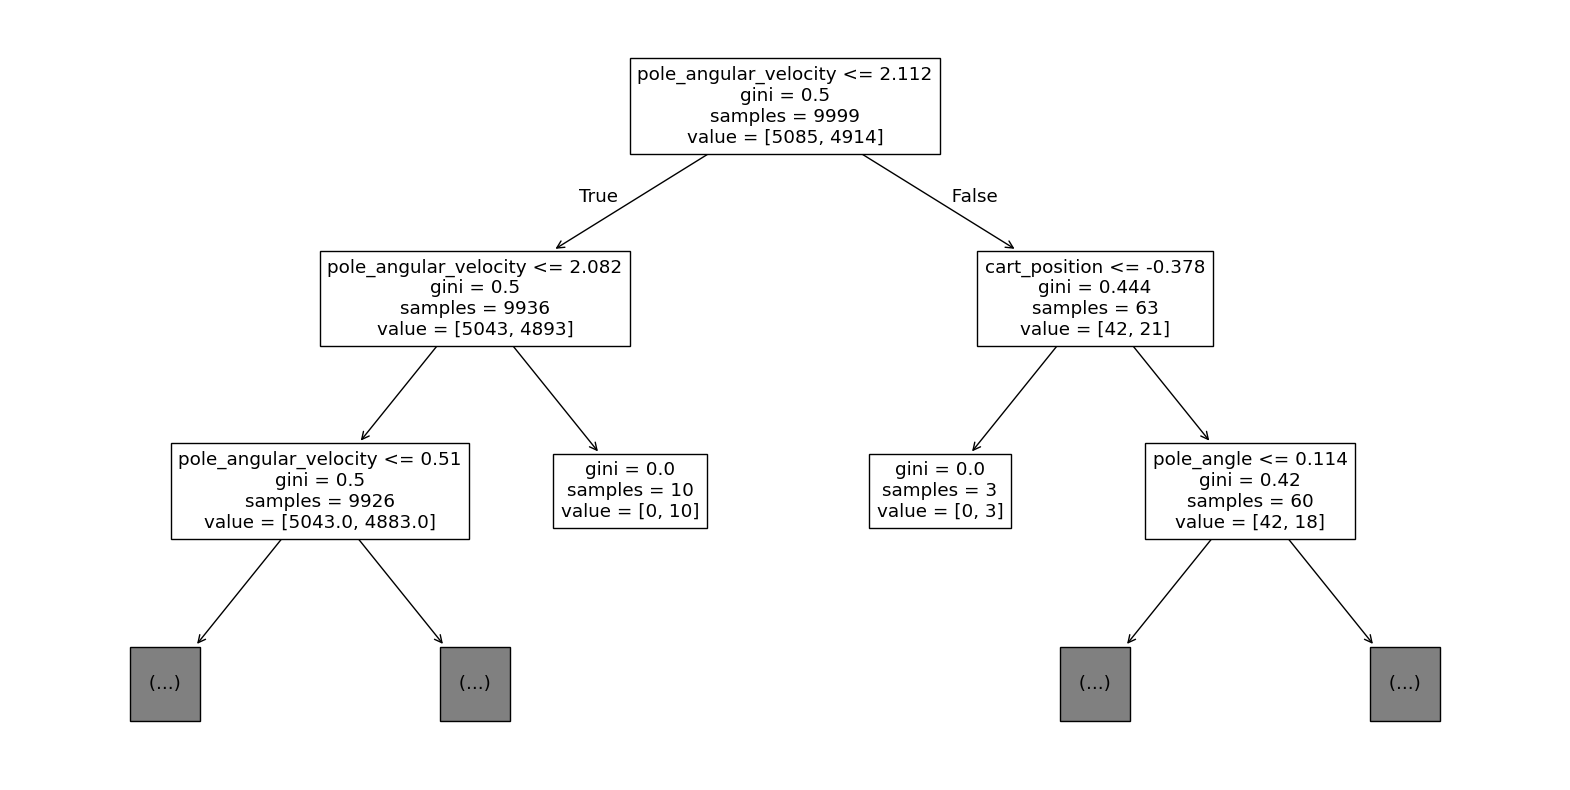

In [13]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(20,10))
feature_names = ["cart_position", "cart_velocity", "pole_angle", "pole_angular_velocity"]

plot_tree(model, max_depth=2, feature_names=feature_names, ax=ax);

In [14]:
class ModelAgent(Agent):
    def __init__(self, model):
        self.model = model
    
    def act(self, observation):
        action = self.model.predict(observation.reshape(1,4)).item()
        return action

In [15]:
agent = ModelAgent(model)

evaluate_agent(agent)

22.5

In [16]:
agent.model

,criterion,'gini'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [17]:
play_episode(agent)

Authorization required, but no authorization protocol specified



## Bookmarks

- https://gymnasium.farama.org/environments/classic_control/cart_pole/
- https://www.kaggle.com/learn/intro-to-game-ai-and-reinforcement-learning
- https://gymnasium.farama.org/
- https://gymnasium.farama.org/tutorials/index.html